In [13]:
import torch
import torch.nn as nn
 
import torchvision.datasets as datasets
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, 
                               kernel_size = 5, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, 
                               kernel_size = 5, stride = 1, padding = 0)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, 
                               kernel_size = 5, stride = 1, padding = 0)
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)
        self.tanh = nn.Tanh()
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avgpool(x)
        x = self.conv3(x)
        x = self.tanh(x)

        x = x.reshape(x.shape[0], -1)
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x

model = LeNet()
x = torch.randn(64,1,32,32)
output = model(x)
 

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001
num_epochs = 4

train_dataset = datasets.MNIST(root='dataset/', train=True, 
                               transform=transforms.Compose([
                                   transforms.Pad(2), 
                                   transforms.ToTensor()]), 
                               download=True)

test_dataset = datasets.MNIST(root='dataset/', 
                              train=False, 
                              transform=transforms.Compose([
                                  transforms.Pad(2), 
                                  transforms.ToTensor()]), 
                              download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)
dataset_sizes = {'train':len(train_dataset), 'test':len(test_dataset)}

model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from IPython.display import HTML, display
class ProgressMonitor(object):
    """
    Custom IPython progress bar for training
    """
    
    tmpl = """
        <p>Loss: {loss:0.4f}   {value} / {length}</p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
    """
 
    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))


In [10]:
dataloaders = [train_loader, test_loader]
first_epoch = 1
since = time.time() 
best_loss = 999999
best_epoch = -1
last_train_loss = -1
plot_train_loss = []
plot_valid_loss = []
plot_acc = []


for epoch in range(first_epoch, first_epoch + num_epochs):
    print()
    print('Epoch', epoch)
    running_loss = 0.0
    valid_loss = 0.0

    # train phase
    model.train()

    # create a progress bar
    progress = ProgressMonitor(length=dataset_sizes["train"])

    for data in dataloaders[0]:
        # Move the training data to the GPU
        inputs, labels  = data
        batch_size = inputs.shape[0]

        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear previous gradient computation
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.data * batch_size
        # update progress bar
        progress.update(batch_size, running_loss)


    epoch_loss = running_loss / dataset_sizes["train"]
    print('Training loss:', epoch_loss.item())
    #writer.add_scalar('Training Loss', epoch_loss, epoch)
    plot_train_loss.append(epoch_loss)

    # validation phase
    model.eval()
    # We don't need gradients for validation, so wrap in 
    # no_grad to save memory



    test_labels = []
    test_preds = []

    with torch.no_grad():
        for data in dataloaders[-1]:
            inputs, labels  = data
            batch_size = inputs.shape[0]

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            # calculate the loss
            optimizer.zero_grad()
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)


            test_labels.extend( list(labels.numpy()) )
            test_preds.extend( list(preds.detach().numpy() ))


            # update running loss value
            valid_loss += loss.data * batch_size

    acc = accuracy_score( test_labels, test_preds)
    epoch_valid_loss = valid_loss / dataset_sizes["test"]
    print('Validation loss:', epoch_valid_loss.item(), f"accuracy : {acc}")
    plot_valid_loss.append(epoch_valid_loss)
    plot_acc.append(acc)
    #writer.add_scalar('Validation Loss', epoch_valid_loss, epoch)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#plot_train_loss, plot_valid_loss, model




Epoch 1


Training loss: 0.2949717044830322
Validation loss: 0.11246976256370544 accuracy : 0.9663

Epoch 2


Training loss: 0.09374650567770004
Validation loss: 0.08799714595079422 accuracy : 0.9726

Epoch 3


Training loss: 0.06139141693711281
Validation loss: 0.0632345974445343 accuracy : 0.9784

Epoch 4


Training loss: 0.04713504761457443
Validation loss: 0.052075378596782684 accuracy : 0.9835
Training complete in 5m 0s


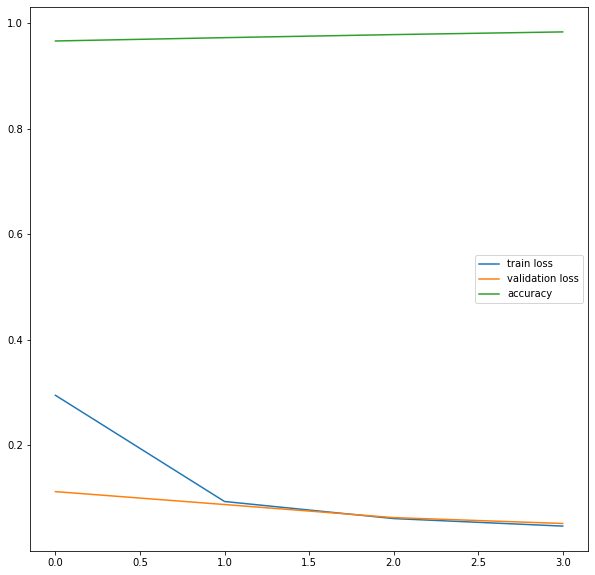

In [18]:
plt.figure( figsize = (10,10))
plt.plot( range(epoch), plot_train_loss, label="train loss")
plt.plot( range(epoch), plot_valid_loss, label="validation loss")
plt.plot( range(epoch), plot_acc, label="accuracy")
plt.legend()
plt.show()